In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import scipy.stats as st
print("Libraries imported successfully.\n")
import warnings
warnings.filterwarnings('ignore')


Libraries imported successfully.



In [12]:
test_df = pd.read_csv('test_data.csv')
print(f"Test data shape: {test_df.shape}\n")


Test data shape: (1012, 96)



In [13]:
# --- Save Index separately ---
test_index = test_df['Index'].copy()


In [14]:
# --- Drop Index column for processing ---
X_test_raw = test_df.drop(columns=['Index'])


In [15]:
# --- Preprocessing Step 1: Gaussian Transformation ---
print("Applying PowerTransformer (Yeo-Johnson) on test data...")
pt = PowerTransformer(method='yeo-johnson')
X_test_gauss = pd.DataFrame(pt.fit_transform(X_test_raw), columns=X_test_raw.columns)
print("Transformation applied.\n")

Applying PowerTransformer (Yeo-Johnson) on test data...
Transformation applied.



In [16]:
# --- Preprocessing Step 2: Winsorization ---
print("Applying winsorization on heavy-tailed features...")
# Identify heavy-tailed features
stats = X_test_gauss.agg(['mean', 'std', 'skew', 'kurt']).T
heavy_skew = stats.index[stats['skew'].abs() > 3]
heavy_kurt = stats.index[stats['kurt'].abs() > 30]
heavy_features = sorted(set(heavy_skew) | set(heavy_kurt))

def winsorize_series(s, p=0.01):
    return pd.Series(st.mstats.winsorize(s, limits=[p, p]), index=s.index)

X_test_wins = X_test_gauss.copy()
for col in heavy_features:
    X_test_wins[col] = winsorize_series(X_test_wins[col])

print("Winsorization completed.\n")


Applying winsorization on heavy-tailed features...
Winsorization completed.



In [17]:
# --- Preprocessing Step 3: Feature Selection ---
selected_features = [
' ROA(C) before interest and depreciation before interest',
       ' Operating Expense Rate', ' Long-term Liability to Current Assets',
       ' Inventory/Current Liability', ' Total expense/Assets',
       ' Long-term fund suitability ratio (A)',
       ' Inventory Turnover Rate (times)', ' Current Asset Turnover Rate',
       ' Revenue per person', ' Research and development expense rate',
       ' Current Ratio', ' Tax rate (A)', ' Total Asset Growth Rate',
       ' Revenue Per Share (Yuan ¥)', ' Current Liabilities/Liability',
       ' Fixed Assets Turnover Frequency',
       ' Interest-bearing debt interest rate', ' Allocation rate per person',
       ' Total assets to GNP price', ' Contingent liabilities/Net worth',
       ' Total debt/Total net worth', ' Operating Gross Margin',
       ' Cash flow rate', ' Average Collection Days',
       ' Degree of Financial Leverage (DFL)', ' Accounts Receivable Turnover',
       ' Net Value Growth Rate', ' Realized Sales Gross Profit Growth Rate'   
]




X_test_final = X_test_wins[selected_features]
print(f"Test data final shape after feature selection: {X_test_final.shape}\n")


Test data final shape after feature selection: (1012, 28)



Generating correlation heatmap of test data...


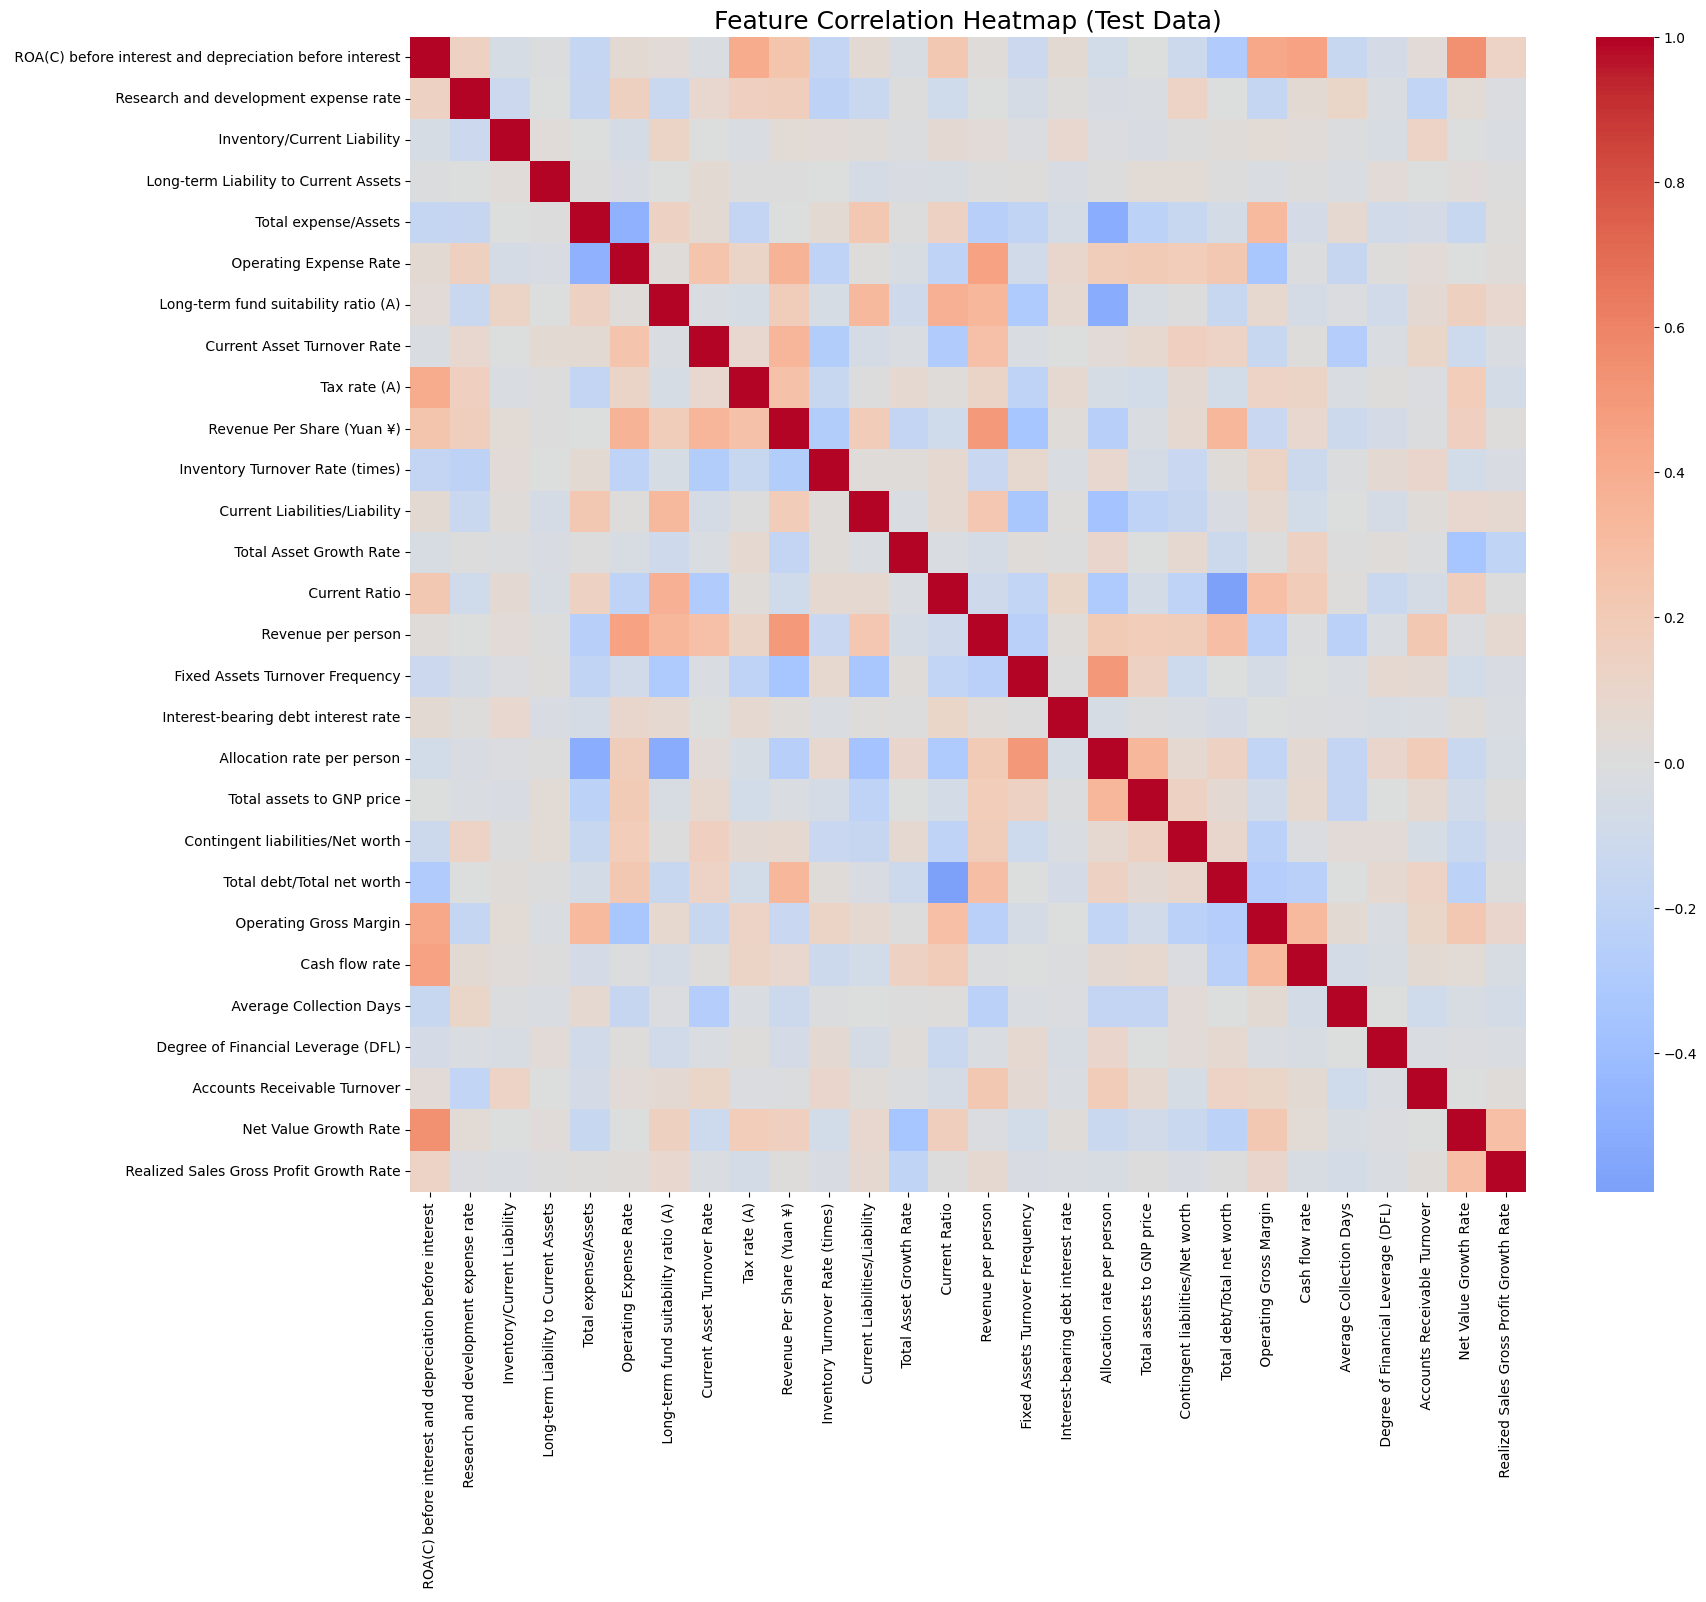

In [18]:
# Correlation Heatmap 
print("Generating correlation heatmap of test data...")
plt.figure(figsize=(18, 15))
sns.heatmap(X_test_final.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap (Test Data)', fontsize=18)
plt.show()


In [19]:
# --- Load Cluster Classifier ---
print("Loading saved cluster classifier model...")
cluster_classifier = joblib.load('cluster_classifier_rf.joblib')
print("Cluster classifier model loaded.\n")

# --- Predict Cluster IDs ---
print("Predicting cluster IDs for test companies...")
test_clusters = cluster_classifier.predict(X_test_final)
print("Cluster IDs predicted.\n")


# Create "Cluster" column with Cluster IDs for all test datapoints
X_test_final["Cluster"] = test_clusters

#add Index column back
X_test_final["Index"] = test_index

# --- Cluster ID Distribution ---
print("Visualizing cluster ID distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x=test_clusters)
plt.title('Test Data Cluster ID Distribution', fontsize=16)
plt.xlabel('Predicted Cluster ID')
plt.ylabel('Number of Companies')
plt.show()

# --- Print Cluster Summary Table ---
cluster_df = pd.DataFrame({
    "cluster": test_clusters
})

# Summarize just the total number of companies per cluster
summary = (
    cluster_df
    .groupby("cluster")
    .size()                    
    .to_frame(name="total")     
    .sort_index()
)

# --- Display
print("\nCluster composition (Test Data):")
display(summary)

Loading saved cluster classifier model...
Cluster classifier model loaded.

Predicting cluster IDs for test companies...


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [27]:
X_test_final.head()

,ROA(C) before interest and depreciation before interest,Research and development expense rate,Inventory/Current Liability,Long-term Liability to Current Assets,Total expense/Assets,Operating Expense Rate,Long-term fund suitability ratio (A),Current Asset Turnover Rate,Tax rate (A),Revenue Per Share (Yuan ¥),...,Total debt/Total net worth,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Index
0,-1.459946,-1.125416,0.912864,-0.236364,1.662563,-0.703378,-0.176836,-0.466866,-1.047772,-0.716850,...,-0.941278,0.091600,-0.844495,0.419707,-0.104267,-0.227334,-0.724296,-0.095799,4,0
1,-0.165694,-1.125428,-0.296419,1.701984,-0.437938,-0.703425,-0.712934,2.140879,0.980754,-0.509507,...,1.079342,0.181454,0.753310,-0.811542,-0.022674,2.204948,-2.459264,-0.064827,2,1
2,-0.095537,1.049487,-0.230439,-0.243814,0.017907,-0.703425,0.057692,-0.466889,-1.047772,-0.911940,...,-0.861100,-0.170333,0.368231,-0.023698,-0.087786,-0.182709,-0.303738,-0.015508,4,2
3,1.231890,0.705075,-0.225400,0.015093,-0.450678,1.422080,1.018201,2.142527,0.607887,2.003014,...,-0.000242,-0.606041,0.252749,-0.285763,-0.086782,-0.124430,0.222919,-0.024956,3,3
4,-1.753887,-1.125428,-0.198821,-0.096034,1.340532,-0.703393,-0.722386,-0.466951,-1.047772,-0.420092,...,-0.015192,-0.633408,-0.442563,0.071119,-0.152320,-0.195731,-1.240521,-0.080510,1,4



Cluster 1 Bankruptcy Prediction Summary:


,count,percentage
Prediction,,
Healthy,269,99.63
Predicted Bankrupt,1,0.37


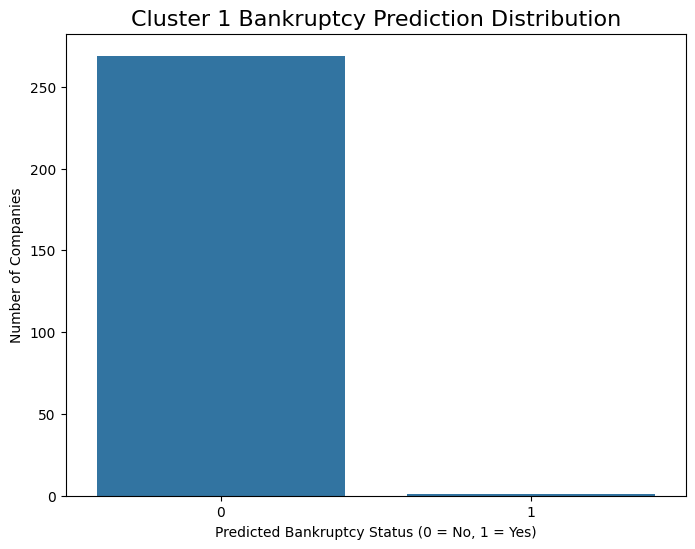

In [35]:
# CLUSTER 1 MODEL - SWATHI 

df_cl1 = X_test_final[X_test_final["Cluster"]==1]

# Save Indexes to attach back later
cl1_indexes = df_cl1["Index"]

# function to further process test data for cluster 1 model
def process_data_cl1(df):
    X_selected = df[[' Total expense/Assets', ' Revenue Per Share (Yuan ¥)', ' Revenue per person', ' Total debt/Total net worth']]
    return X_selected
        

X_selected = process_data_cl1(df_cl1)

# -- Load in model ------
model =joblib.load('cluster1_stacking_model.joblib')
# Make prediction on all datapoints in Cluster 1 df
cl1_predictions = []
for i, row in X_selected.iterrows():
    company_features = row.values.reshape(1, -1)
    prediction = model.predict(company_features)[0]
    cl1_predictions.append(prediction)
    

# -- Append "Predictions" and "Index" column to X_selected df ----
X_selected["Prediction"] = cl1_predictions
X_selected["Index"] = cl1_indexes
X_selected.head()


# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_selected["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display ---
print("\nCluster 1 Bankruptcy Prediction Summary:")
display(summary)

# -- Plot ----
plt.figure(figsize=(8, 6))
sns.countplot(x=cl1_predictions)
plt.title('Cluster 1 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()

Prediction distribution:
 0    0.525714
1    0.474286
Name: Bankrupt?, dtype: float64


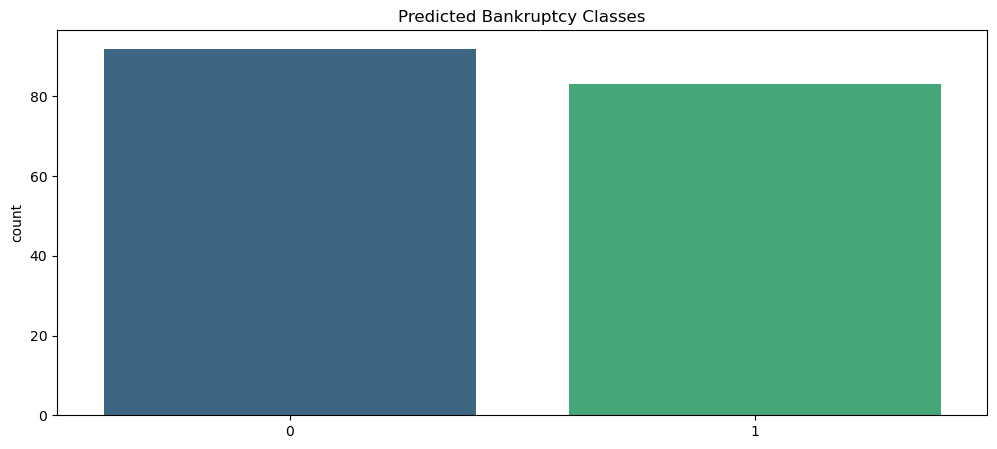

In [29]:
# Cluster 2 Model Shreel Patel
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
df_cl2 = X_test_final[X_test_final["Cluster"]==2]
def safe_polynomial_transform(X, degree=10, poly_object=None, scaler=None):
   
    
    X_clean = X.replace([np.inf, -np.inf], np.nan).copy()
    

    X_clean.fillna(X_clean.mean(), inplace=True)
    
  
    for col in X_clean.columns:
        q1 = X_clean[col].quantile(0.01)
        q99 = X_clean[col].quantile(0.99)
        X_clean[col] = np.clip(X_clean[col], q1, q99)
    

    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
    else:
        X_scaled = scaler.transform(X_clean)
    

    if poly_object is None:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X_scaled)
    else:
        X_poly = poly_object.transform(X_scaled)
 
    max_float32 = np.finfo(np.float32).max
    X_poly = np.clip(X_poly, -max_float32, max_float32)
    
    return X_poly, poly, scaler

# Load test data
X_test = df_cl2[[
    ' Fixed Assets Turnover Frequency',
    ' Revenue per person',
    ' Operating Expense Rate'
]].copy()


try:
    poly = joblib.load('poly_features.joblib')
    scaler = joblib.load('scaler.joblib')
except:
    poly, scaler = None, None


X_test_poly, poly, scaler = safe_polynomial_transform(
    X_test, 
    degree=10,
    poly_object=poly,
    scaler=scaler
)





model = joblib.load('cluster_2_shreel_stacked_model.joblib')  # Update filename
predictions = model.predict(X_test_poly)
probabilities = model.predict_proba(X_test_poly)[:, 1]  # Probability of class 1

submission = pd.DataFrame({
    'Index': range(1, len(predictions)+1),
    'Bankrupt?': predictions
})

# Visualization
plt.figure(figsize=(12, 5))

sns.countplot(x=predictions, palette='viridis')
plt.title('Predicted Bankruptcy Classes')



# Save results
submission.to_csv('bankruptcy_predictions.csv', index=False)
print("Prediction distribution:\n", submission['Bankrupt?'].value_counts(normalize=True))

In [12]:
models = {
    4: joblib.load('khushi_cluster3_stacking_model.joblib')
}
print("model loaded successfully.\n")

# --- Predict Bankruptcy Status ---
print("Predicting bankruptcy status for each company...")
predictions = []

for i, row in X_test_final.iterrows():
    company_features = row.values.reshape(1, -1)
    cluster_id = int(test_clusters[i])  # No +1 shifting needed
    
    
    if cluster_id == 4:
        model = models[cluster_id]
        prediction = model.predict(company_features)[0]
    
    else:
        prediction = 0  # If no stacking model yet, predict 0 (Not Bankrupt)

    predictions.append(prediction)

print("Bankruptcy prediction completed.\n")


model loaded successfully.

Predicting bankruptcy status for each company...
Bankruptcy prediction completed.



Visualizing bankruptcy prediction distribution...


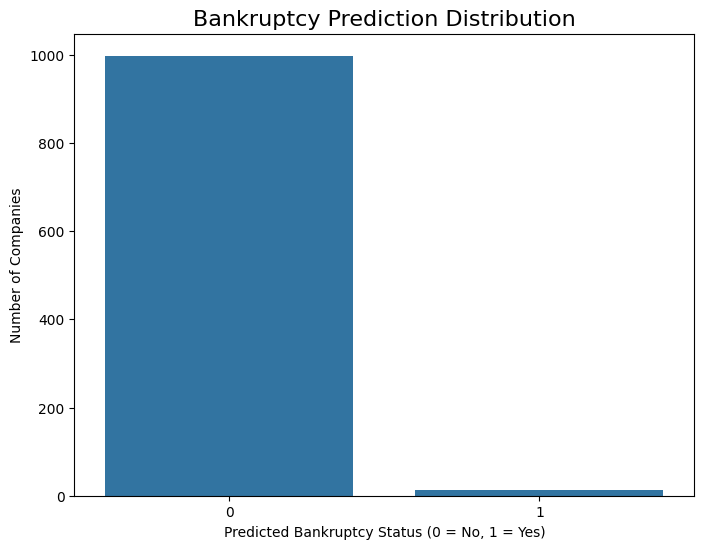

In [13]:
print("Visualizing bankruptcy prediction distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x=predictions)
plt.title('Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()


In [14]:
print("Creating final submission file...")
submission = pd.DataFrame({
    'Index': test_index,
    'Bankrupt?': predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!\n")


Creating final submission file...
Submission file 'submission.csv' created successfully!

